Data analysis for firm dynamics project

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

from shapely.geometry import Point
from scipy.stats import expon

Creating the dataframes

In [ ]:
df = pd.read_csv('ACRA_w_SO.csv')

# Drop rows where Coordinate_X or Coordinate_Y is -1
df = df[(df['Coordinate_X'] != -1) & (df['Coordinate_Y'] != -1)]

# Initialise new dataframe for data we want to analyse
df_analysis = pd.DataFrame()
df_analysis['uen'] = df['uen']
df_analysis['Sector'] = df['Sector']
df_analysis['status'] = df['status']

# Convert the 5 struck off dates to datetime
date_cols = [f'Struck Off Date {i}' for i in range(1, 6)]
df[date_cols] = df[date_cols].apply(pd.to_datetime)

# Calculate the average date for each firm
df_analysis['Exit Date'] = df[date_cols].mean(axis=1)
df_analysis['Entry Date'] = df['registration_incorporation_date']

In [126]:
df.head()

,Unnamed: 0,uen,entity_status_description,registration_incorporation_date,primary_ssic_code,no_of_officers,postal_code,Sector,Coordinate_X,Coordinate_Y,Struckoff_date,status,Struck Off Date 1,Struck Off Date 2,Struck Off Date 3,Struck Off Date 4,Struck Off Date 5
0,0,53376145W,Ceased Registration,2018-01-13T10:32:56,81211,1,786092,N,26965.946069,43165.257359,NaN,0,2019-07-13,2019-07-13,2022-07-13,2021-07-13,2018-07-13
1,1,53290857X,Live,2015-02-26T12:02:44,95220,1,571275,S,29135.238841,37635.655227,NaN,1,NaT,NaT,NaT,NaT,NaT
3,3,200412424K,Live Company,2004-09-28T17:56:29,47713,5,658077,G,19640.197381,35557.098364,NaN,1,NaT,NaT,NaT,NaT,NaT
4,4,53396472E,Ceased Registration,2019-04-11T21:20:43,49215,1,082001,H,29026.583059,28597.376389,NaN,0,2019-10-11,2019-10-11,2021-10-11,2022-10-11,2019-10-11
5,5,48376900B,na,1993-04-12T00:00:00,96021,3,557801,S,31540.107755,38516.964477,NaN,0,1998-10-12,1994-10-12,2003-10-12,1998-10-12,2003-10-12


Adding age column

In [275]:
# Convert Entry Date to datetime
df_analysis['Entry Date'] = pd.to_datetime(df_analysis['Entry Date'])

# Calculate age in years
current_time = df_analysis['Exit Date'].max()
df_analysis['Age'] = (df_analysis['Exit Date'].fillna(current_time) - df_analysis['Entry Date']).dt.days / 365.25

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Age,Region,Coordinate_X,Coordinate_Y,Region2
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,2.291581,B3,26965.946069,43165.257359,NR
1,53290857X,S,1,NaT,2015-02-26 12:02:44,7.841205,C2,29135.238841,37635.655227,CR
3,200412424K,G,1,NaT,2004-09-28 17:56:29,18.253251,B2,19640.197381,35557.098364,WR
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,1.497604,C1,29026.583059,28597.376389,CR
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,6.699521,C2,31540.107755,38516.964477,NER


In [193]:
# Testing for number of young firms
young_firms = df_analysis[(df_analysis['Age'] < 3) & (df_analysis['status'] == 1)]

print(young_firms.head())
print(young_firms.count())

            uen Sector  status Exit Date          Entry Date       Age Region  \
98   202140885W      M       1       NaT 2021-11-24 00:00:00  1.100616     C1   
104   53416222C      F       1       NaT 2020-07-02 12:58:27  2.494182     D2   
116  202120469C      M       1       NaT 2021-06-10 00:00:00  1.557837     B2   
157  202234183E      K       1       NaT 2022-09-27 00:00:00  0.260096     B1   
159   53439730A      G       1       NaT 2021-09-14 18:37:59  1.292266     C3   

     Coordinate_X  Coordinate_Y Region2  
98   29945.885092  30523.420377      CR  
104  42035.625938  38525.118006      ER  
116  23417.962014  34197.101678      CR  
157  25584.380811  29720.932105      CR  
159  35807.638754  42214.722990     NER  
uen             157927
Sector          157927
status          157927
Exit Date            0
Entry Date      157927
Age             157927
Region          157927
Coordinate_X    157927
Coordinate_Y    157927
Region2         157927
dtype: int64


Splitting SG into 12 regions

In [ ]:
# Should I bound by furthest firms? Or based on the area of Singapore instead?
x_min, x_max = df['Coordinate_X'].min()-0.1, df['Coordinate_X'].max()+0.1
y_min, y_max = df['Coordinate_Y'].min()-0.1, df['Coordinate_Y'].max()+0.1

print(f"Coordinate_X: min={x_min}, max={x_max}")
print(f"Coordinate_Y: min={y_min}, max={y_max}")

df_analysis['Coordinate_X'] = df['Coordinate_X']
df_analysis['Coordinate_Y'] = df['Coordinate_Y']

# Setting boundaries for the 12 regions
x_array = np.linspace(x_min, x_max, 5)
y_array = np.linspace(y_min, y_max, 4)

print(x_array)
print(y_array)

# Define region labels for x and y
x_labels = ['A', 'B', 'C', 'D']
y_labels = ['1', '2', '3']

# Assign x region (A, B, C, D) based on Coordinate_X
x_region = pd.cut(df['Coordinate_X'], bins=x_array, labels=x_labels, include_lowest=True, right=False)

# Assign y region (1, 2, 3) based on Coordinate_Y
y_region = pd.cut(df['Coordinate_Y'], bins=y_array, labels=y_labels, include_lowest=True, right=False)

# Combine to form region code (e.g., A1, B2, etc.)
df_analysis['Region'] = x_region.astype(str) + y_region.astype(str)

df_analysis.head()

Coordinate_X: min=3371.661129201186, max=53137.16000076222
Coordinate_Y: min=23536.28834579989, max=50187.241339099855
[ 3371.6611292  15813.03584709 28254.41056498 40695.78528287
 53137.16000076]
[23536.2883458  32419.93934357 41303.59034133 50187.2413391 ]


,uen,Sector,status,Exit Date,Entry Date,Age,Region
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,2.291581,B3
1,53290857X,S,1,NaT,2015-02-26 12:02:44,10.327173,C2
3,200412424K,G,1,NaT,2004-09-28 17:56:29,20.739220,B2
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,1.497604,C1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,6.699521,C2


Plotting age distribution, by region

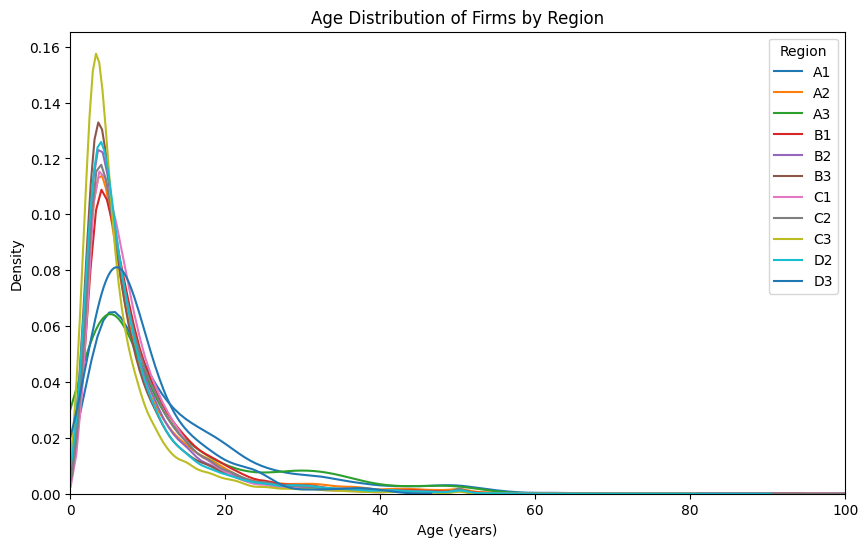

In [68]:
# Overlayed age distributions for each region
plt.figure(figsize=(10, 6))

for region, group in df_analysis.groupby('Region'):
    sns.kdeplot(
        group['Age'].dropna(),
        label=region,
        fill=False,
        common_norm=False
    )

plt.title('Age Distribution of Firms by Region')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend(title='Region')
plt.xlim(left=0, right=100)
plt.show()

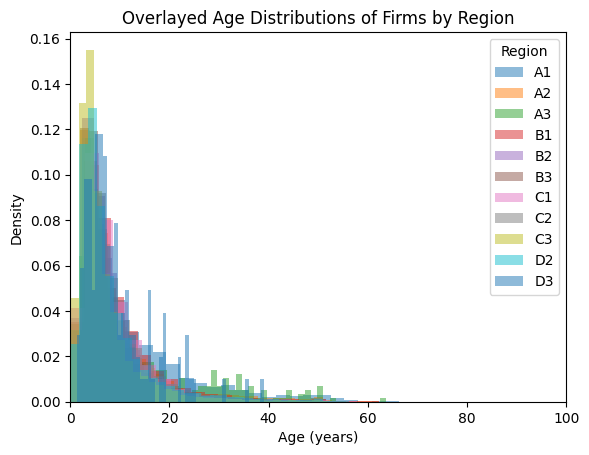

In [144]:
fig, ax = plt.subplots()

for region, group in df_analysis.groupby('Region'):
    plt.hist(
        group['Age'].dropna(),
        bins=50,
        alpha=0.5,
        label=region,
        density=True
    )

plt.title('Overlayed Age Distributions of Firms by Region')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend(title='Region')
plt.xlim(left=0, right=100)
plt.show()

Trying geopandas instead

In [194]:
# Read the KML file
regions = gpd.read_file('region_boundary.geojson')
regions = regions.to_crs("EPSG:3414") # Convert to Singapore CRS

print(regions['Description'][0]) # WR
print(regions['Description'][1]) # NR
print(regions['Description'][2]) # NER
print(regions['Description'][3]) # ER
print(regions['Description'][4]) # CR

# Map the region names to the corresponding codes
region_map = {
    'kml_1': 'WR',
    'kml_2': 'NR',
    'kml_3': 'NER',
    'kml_4': 'ER',
    'kml_5': 'CR'
}
regions['Name'] = regions['Name'].map(region_map)

regions.head()

<center><table><tr><th colspan='2' align='center'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>REGION_N</th> <td>WEST REGION</td> </tr><tr bgcolor=""> <th>REGION_C</th> <td>WR</td> </tr><tr bgcolor="#E3E3F3"> <th>INC_CRC</th> <td>1B3014B2A6F803C8</td> </tr><tr bgcolor=""> <th>FMEL_UPD_D</th> <td>20191223152213</td> </tr></table></center>
<center><table><tr><th colspan='2' align='center'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>REGION_N</th> <td>NORTH REGION</td> </tr><tr bgcolor=""> <th>REGION_C</th> <td>NR</td> </tr><tr bgcolor="#E3E3F3"> <th>INC_CRC</th> <td>9642FA9C45608EBD</td> </tr><tr bgcolor=""> <th>FMEL_UPD_D</th> <td>20191223152214</td> </tr></table></center>
<center><table><tr><th colspan='2' align='center'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>REGION_N</th> <td>NORTH-EAST REGION</td> </tr><tr bgcolor=""> <th>REGION_C</th> <td>NER</td> </tr><tr bgcolor="#E3E3F3"> <th>INC_CRC</th> <td>C47E144B70E52625</td> </tr><tr bgcolor=""> <th>FM

,Name,Description,geometry
0,WR,<center><table><tr><th colspan='2' align='cent...,"MULTIPOLYGON Z (((17763.386 15889.099 0, 17758..."
1,NR,<center><table><tr><th colspan='2' align='cent...,"MULTIPOLYGON Z (((32351.432 46848.428 0, 32356..."
2,NER,<center><table><tr><th colspan='2' align='cent...,"MULTIPOLYGON Z (((40653.537 43269.83 0, 40659...."
3,ER,<center><table><tr><th colspan='2' align='cent...,"MULTIPOLYGON Z (((54525.795 30483.93 0, 54532...."
4,CR,<center><table><tr><th colspan='2' align='cent...,"MULTIPOLYGON Z (((28303.146 21724.562 0, 28290..."


In [195]:
# Create a GeoDataFrame from the df_analysis DataFrame
geometry = [Point(xy) for xy in zip(df_analysis['Coordinate_X'], df_analysis['Coordinate_Y'])]
gdf = gpd.GeoDataFrame(df_analysis, geometry=geometry, crs="EPSG:3414")

# Spatial join: assign each firm the region it falls into
gdf_with_region = gpd.sjoin(gdf, regions, how='left', predicate='within')

# Update df_analysis with the mapped region assignments
df_analysis['Region2'] = gdf_with_region['Name'].values

df_analysis.head(10)

,uen,Sector,status,Exit Date,Entry Date,Age,Region,Coordinate_X,Coordinate_Y,Region2
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,2.291581,B3,26965.946069,43165.257359,NR
1,53290857X,S,1,NaT,2015-02-26 12:02:44,7.841205,C2,29135.238841,37635.655227,CR
3,200412424K,G,1,NaT,2004-09-28 17:56:29,18.253251,B2,19640.197381,35557.098364,WR
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,1.497604,C1,29026.583059,28597.376389,CR
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,6.699521,C2,31540.107755,38516.964477,NER
6,53143471X,S,0,2013-11-25 19:12:00,2009-05-26 23:24:53,4.498289,A2,14916.995568,37166.644042,WR
7,31989700A,G,0,1988-10-26 19:12:00,1983-12-03 00:00:00,4.898015,C1,35745.141542,31790.923795,CR
9,53276057C,G,0,2017-08-17 00:00:00,2014-09-24 21:43:51,2.893908,B2,17172.757372,39879.252147,WR
10,200007504H,F,1,NaT,2000-08-29 00:00:00,22.338125,C2,32749.956354,34681.873735,CR
11,201826023E,M,1,NaT,2018-07-31 00:00:00,4.418891,C1,29845.114287,29472.614367,CR


Creating new dataframe filtering out dead firms

In [196]:
df_agedistribution = df_analysis[['uen', 'Sector', 'status', 'Entry Date', 'Exit Date', 'Age', 'Region2']].copy()
df_alive = df_agedistribution[df_agedistribution['status'] == 1]

df_alive.head()

,uen,Sector,status,Entry Date,Exit Date,Age,Region2
1,53290857X,S,1,2015-02-26 12:02:44,NaT,7.841205,CR
3,200412424K,G,1,2004-09-28 17:56:29,NaT,18.253251,WR
10,200007504H,F,1,2000-08-29 00:00:00,NaT,22.338125,CR
11,201826023E,M,1,2018-07-31 00:00:00,NaT,4.418891,CR
16,53374614X,F,1,2017-12-09 15:32:21,NaT,5.056810,CR


Plotting using SG regional boundaries from URA Master Plan data

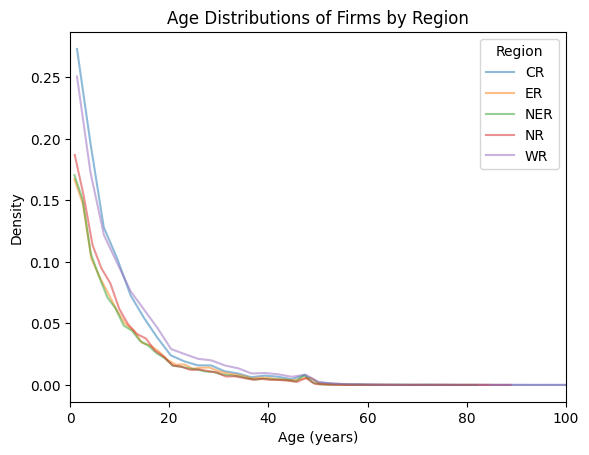

In [201]:
fig, ax = plt.subplots()

for region, group in df_alive.groupby('Region2'):
    counts, bin_edges = np.histogram(group['Age'].dropna(), bins=50)
    # Calculate bin midpoints
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Line plot for age density for each region
    plt.plot(
        bin_midpoints,
        counts / counts.sum(),  # Normalize to get density
        label=region,
        alpha=0.5
    )

plt.title('Age Distributions of Firms by Region')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend(title='Region')
plt.xlim(left=0, right=100)
plt.show()

C:\Users\chong\AppData\Local\Temp\ipykernel_9748\1902783782.py:10: RuntimeWarning: divide by zero encountered in log
  np.log(counts / counts.sum()),  # Normalize to get density


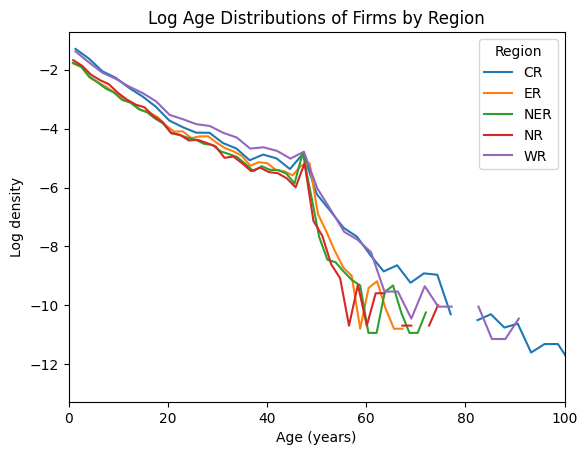

In [243]:
# Plotting log densities for each region

for region, group in df_alive.groupby('Region2'):
    counts, bin_edges = np.histogram(group['Age'].dropna(), bins=50)
    # Calculate bin midpoints
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Line plot for age density for each region
    plt.plot(
        bin_midpoints,
        np.log(counts / counts.sum()),  # Normalize to get density
        label=region,
    )

plt.title('Log Age Distributions of Firms by Region')
plt.xlabel('Age (years)')
plt.ylabel('Log density')
plt.legend(title='Region')
plt.xlim(left=0, right=100)
plt.show()

In [233]:
from scipy.stats import ks_2samp, kruskal

region_names = df_alive['Region2'].dropna().unique()

for i, region1 in enumerate(region_names):
    for region2 in region_names[i+1:]:
        ages1 = df_alive[df_alive['Region2'] == region1]['Age'].dropna()
        ages2 = df_alive[df_alive['Region2'] == region2]['Age'].dropna()
        # Take a random sample of 10000 ages
        sample1 = ages1.sample(n=min(10000, len(ages1)))
        sample2 = ages2.sample(n=min(10000, len(ages2)))
        stat, p_value = ks_2samp(sample1, sample2)
        print(f"KS test between {region1} and {region2}: p-value = {p_value:.4f}")

groups = [
    group['Age'].dropna().sample(n=min(10000, len(group['Age'].dropna())))
    for _, group in df_alive.groupby('Region2')
]
stat, p_value = kruskal(*groups)
print(f"Kruskal-Wallis test across all regions: p-value = {p_value:.4f}")

KS test between CR and WR: p-value = 0.0000
KS test between CR and NR: p-value = 0.5229
KS test between CR and ER: p-value = 0.0000
KS test between CR and NER: p-value = 0.0003
KS test between WR and NR: p-value = 0.0000
KS test between WR and ER: p-value = 0.0003
KS test between WR and NER: p-value = 0.0000
KS test between NR and ER: p-value = 0.0000
KS test between NR and NER: p-value = 0.1074
KS test between ER and NER: p-value = 0.0000
Kruskal-Wallis test across all regions: p-value = 0.0000


Creating a new dataframe for the mean age

In [241]:
df_meanage = pd.DataFrame()

# Group by Region, count total firms, and sum 'status' to get number alive
df_meanage = df_analysis.groupby('Region2').agg(
    Mean_Age=('Age', 'mean'),
).reset_index()

In [242]:
df_meanage.head()

,Region2,Mean_Age
0,CR,7.918186
1,ER,7.603458
2,NER,7.412248
3,NR,7.001449
4,WR,7.645945


In [239]:
from scipy.stats import ttest_ind

ages1 = df_alive[df_alive['Region2'] == 'ER']['Age']
ages2 = df_alive[df_alive['Region2'] == 'WR']['Age']

stat, p_value = ttest_ind(ages1, ages2, equal_var=False)
print(p_value)

3.990718353829245e-05


Analysing age distributions across time

In [253]:
# Creating a dataframe for each region
df_central = df_agedistribution[df_agedistribution['Region2'] == 'CR'].copy()
df_west = df_agedistribution[df_agedistribution['Region2'] == 'WR'].copy()
df_north = df_agedistribution[df_agedistribution['Region2'] == 'NR'].copy()
df_east = df_agedistribution[df_agedistribution['Region2'] == 'ER'].copy()
df_north_east = df_agedistribution[df_agedistribution['Region2'] == 'NER'].copy()

df_central.head()

,uen,Sector,status,Entry Date,Exit Date,Age,Region2
1,53290857X,S,1,2015-02-26 12:02:44,NaT,7.841205,CR
4,53396472E,H,0,2019-04-11 21:20:43,2020-10-10 09:36:00,1.497604,CR
7,31989700A,G,0,1983-12-03 00:00:00,1988-10-26 19:12:00,4.898015,CR
10,200007504H,F,1,2000-08-29 00:00:00,NaT,22.338125,CR
11,201826023E,M,1,2018-07-31 00:00:00,NaT,4.418891,CR


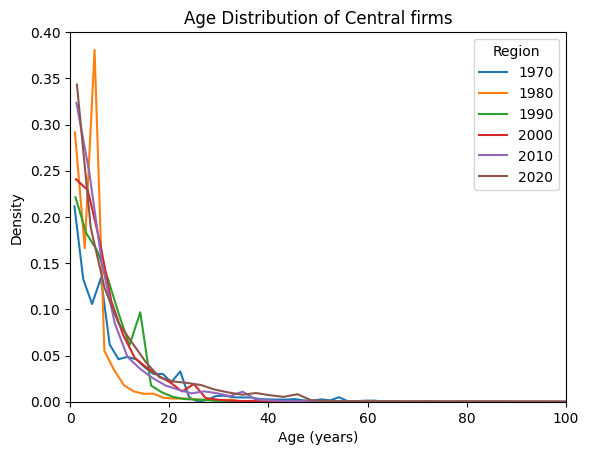

In [ ]:
# Create 10 equally spaced years between 1970 and 2020
years = np.linspace(1970, 2020, 6)

# Convert years to datetime (using January 1st for each year)
dates = pd.to_datetime(years.astype(int).astype(str) + '-01-01')

for date in dates:

    # Filter firms alive at the given date
    df_filtered = df_central[
        (df_central['Entry Date'] < date) &
        ((df_central['Exit Date'].isna()) | (df_central['Exit Date'] > date))
    ].copy()
    df_filtered['Exit Date'] = date
    df_filtered['Age'] = (date - df_filtered['Entry Date']).dt.days / 365.25
    
    # Line plot for age density
    counts, bin_edges = np.histogram(df_filtered['Age'].dropna(), bins=50)
    # Calculate bin midpoints
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(
        bin_midpoints,
        counts / counts.sum(),  # Normalize to get density
        label=f'{date.year}'
    )
plt.title(f'Age Distribution of Central firms')
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend(title='Region')
plt.xlim(left=0, right=100)
plt.ylim(top=0.4, bottom=0)
plt.show()


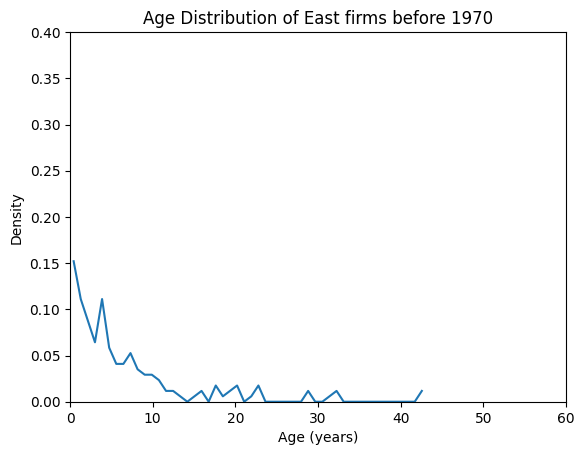

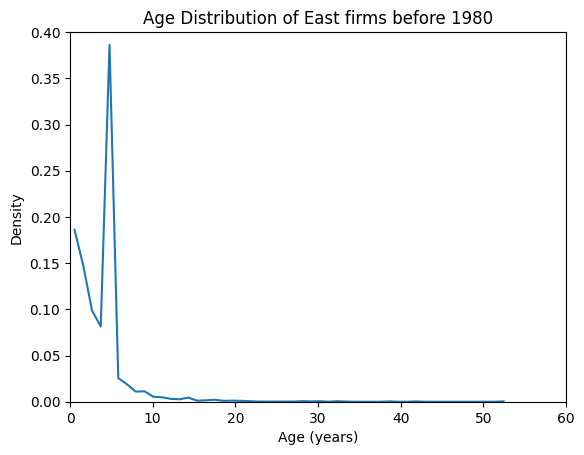

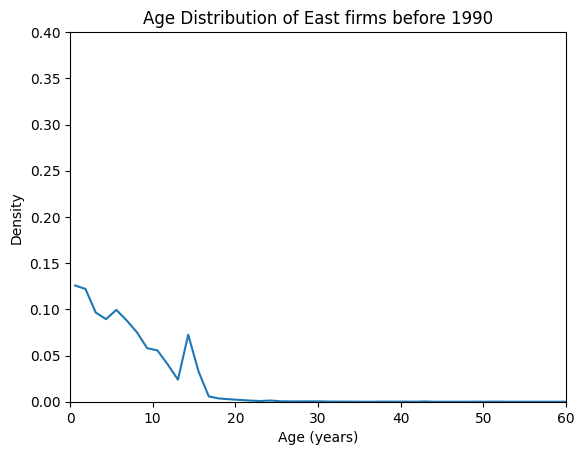

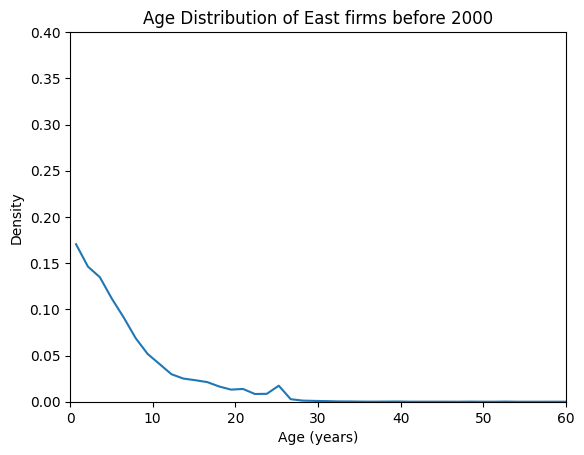

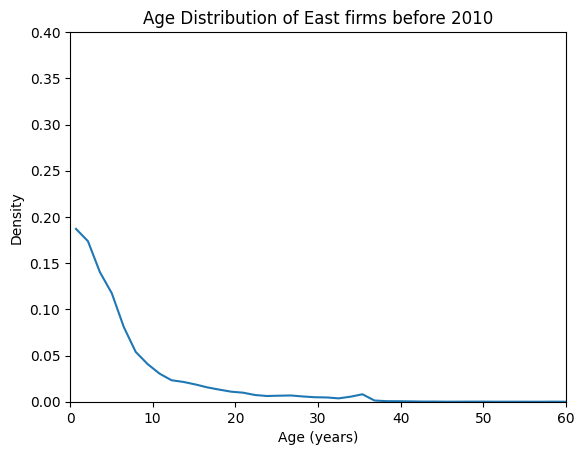

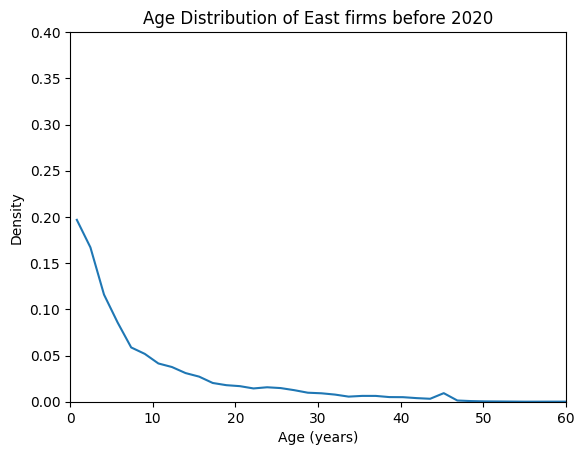

In [334]:
# Create 10 equally spaced years between 1970 and 2020
years = np.linspace(1970, 2020, 6)

# Convert years to datetime (using January 1st for each year)
dates = pd.to_datetime(years.astype(int).astype(str) + '-01-01')

for date in dates:
    fig, ax = plt.subplots()
    # Filter firms alive at the given date
    df_filtered = df_east[
        (df_east['Entry Date'] < date) &
        ((df_east['Exit Date'].isna()) | (df_east['Exit Date'] > date))
    ].copy()
    df_filtered['Exit Date'] = date
    df_filtered['Age'] = (date - df_filtered['Entry Date']).dt.days / 365.25
    
    # Line plot for age density
    counts, bin_edges = np.histogram(df_filtered['Age'].dropna(), bins=50)
    # Calculate bin midpoints
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(
        bin_midpoints,
        counts / counts.sum(),  # Normalize to get density
    )
    plt.title(f'Age Distribution of East firms before {date.year}')
    plt.xlabel('Age (years)')
    plt.ylabel('Density')
    plt.xlim(left=0, right=60)
    plt.ylim(top=0.4, bottom=0)
    plt.show()

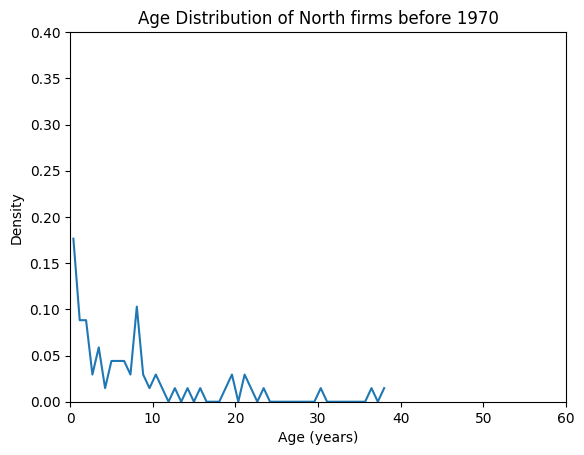

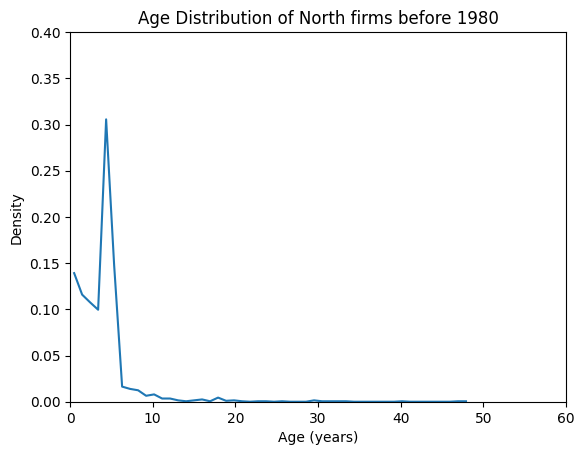

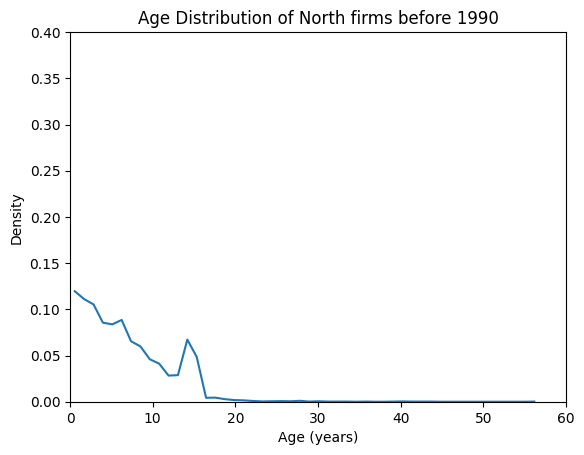

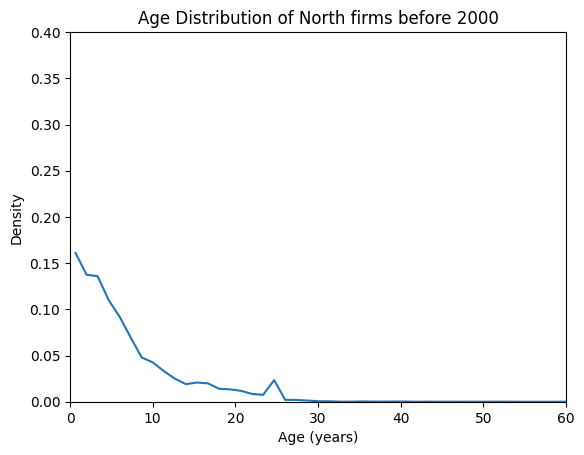

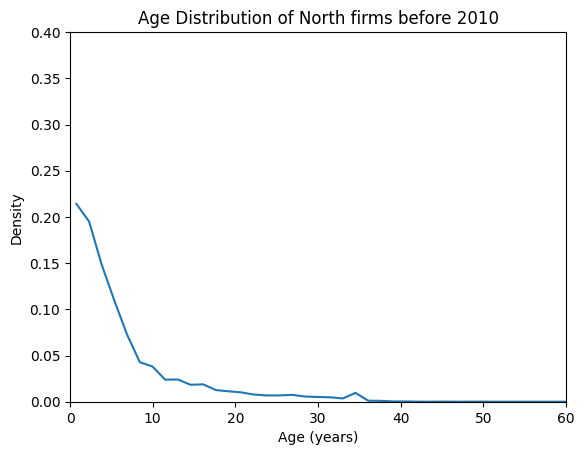

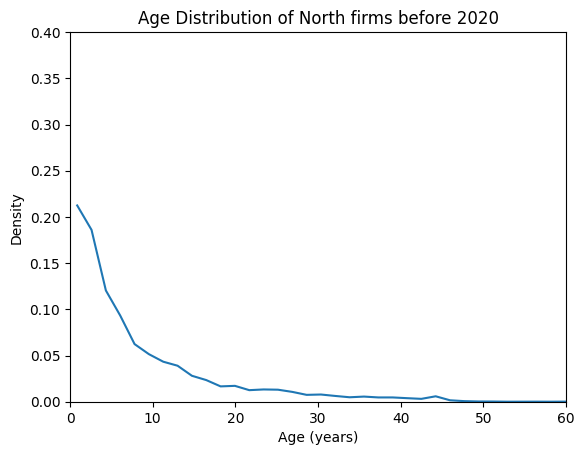

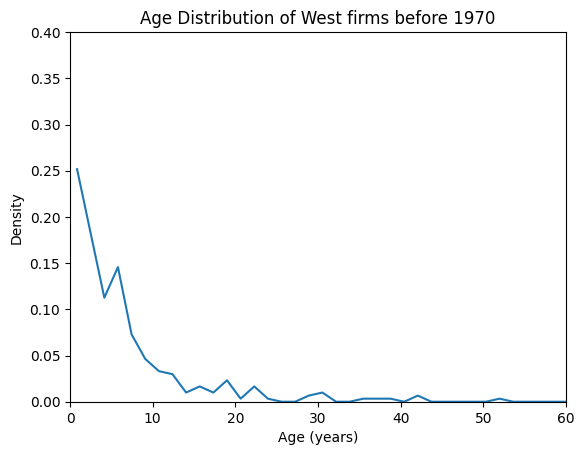

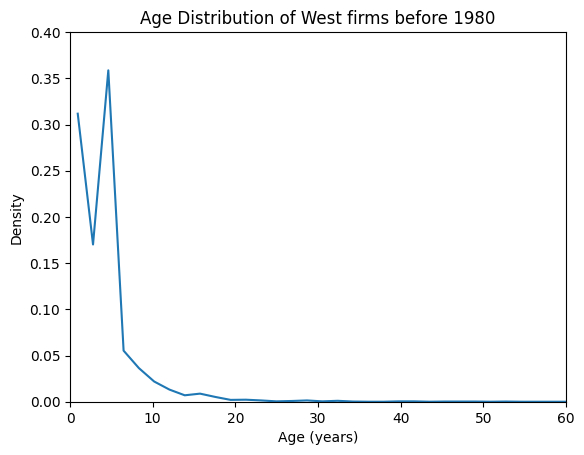

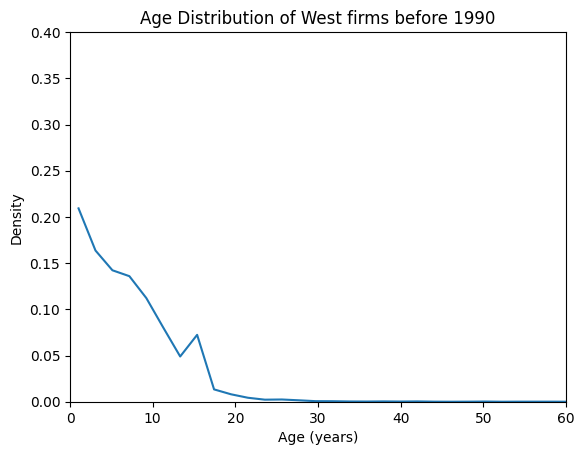

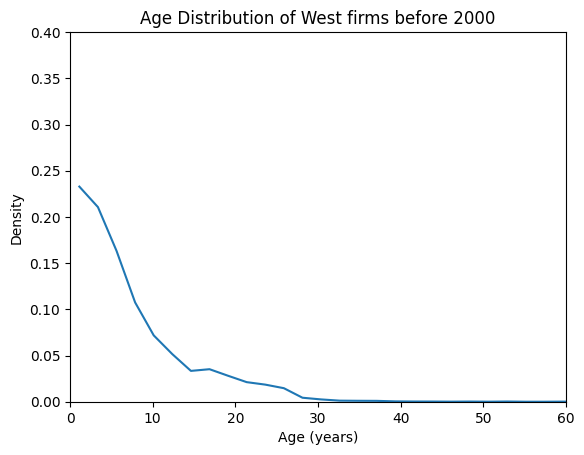

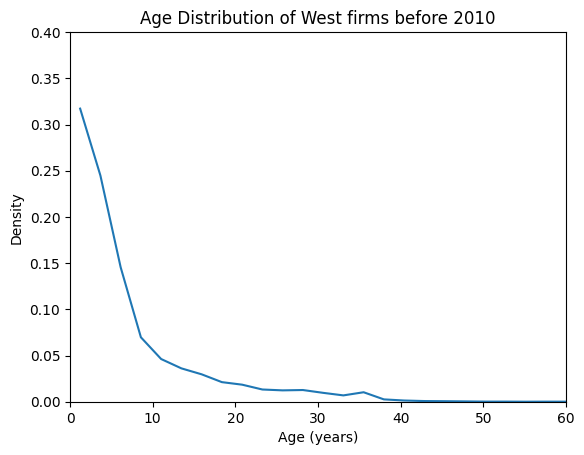

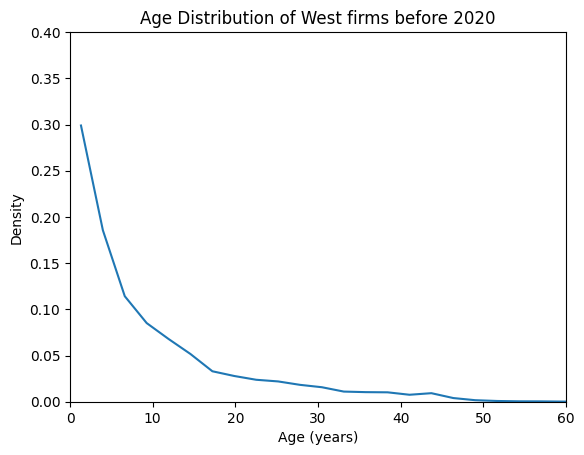

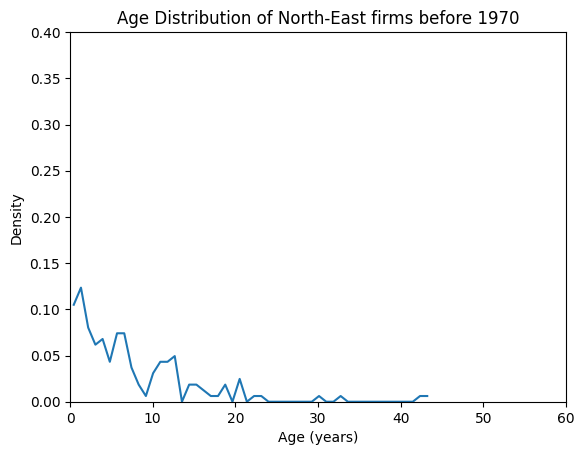

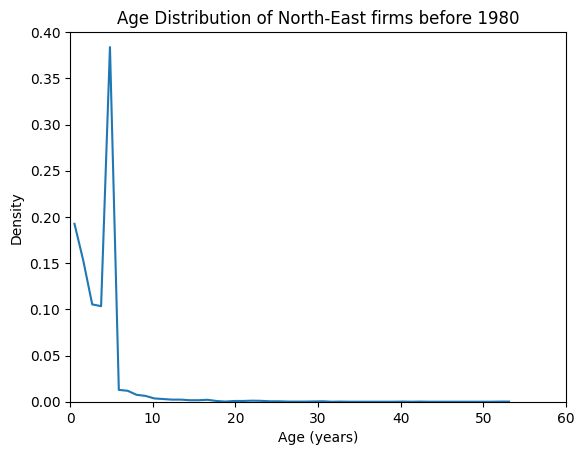

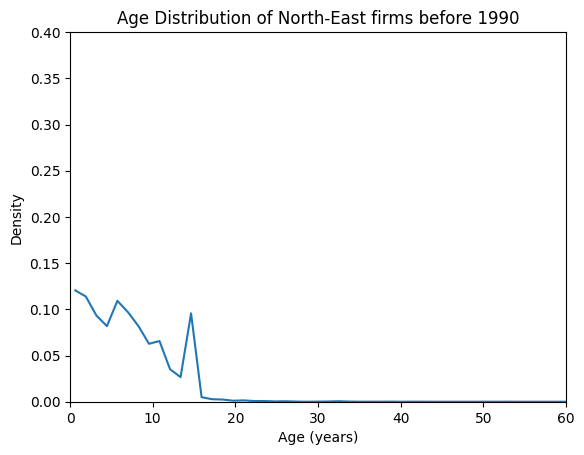

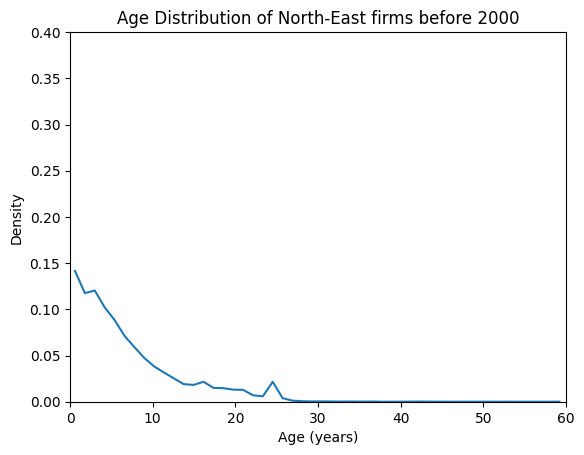

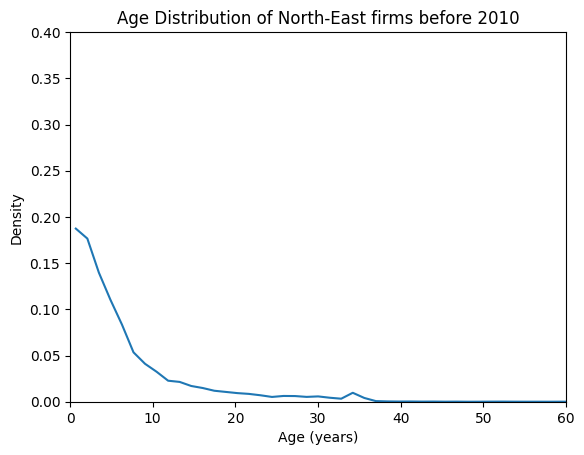

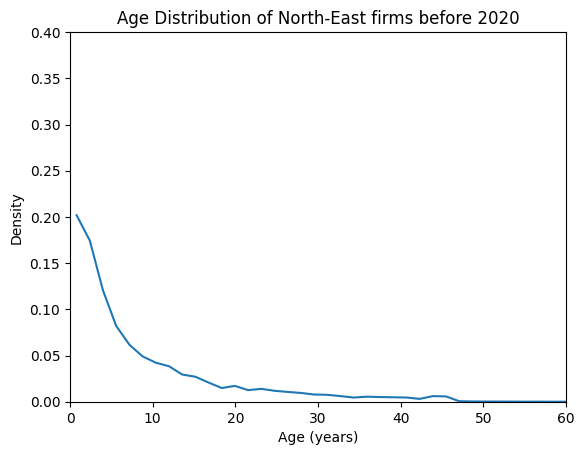

In [333]:
# Plot age distribution over time for North region
years = np.linspace(1970, 2020, 6)
dates = pd.to_datetime(years.astype(int).astype(str) + '-01-01')

for date in dates:
    fig, ax = plt.subplots()
    df_filtered = df_north[
        (df_north['Entry Date'] < date) &
        ((df_north['Exit Date'].isna()) | (df_north['Exit Date'] > date))
    ].copy()
    df_filtered['Exit Date'] = date
    df_filtered['Age'] = (date - df_filtered['Entry Date']).dt.days / 365.25

    counts, bin_edges = np.histogram(df_filtered['Age'].dropna(), bins=50)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(
        bin_midpoints,
        counts / counts.sum(),
    )
    plt.title(f'Age Distribution of North firms before {date.year}')
    plt.xlabel('Age (years)')
    plt.ylabel('Density')
    plt.xlim(left=0, right=60)
    plt.ylim(top=0.4, bottom=0)
    plt.show()

# Plot age distribution over time for West region
for date in dates:
    fig, ax = plt.subplots()
    df_filtered = df_west[
        (df_west['Entry Date'] < date) &
        ((df_west['Exit Date'].isna()) | (df_west['Exit Date'] > date))
    ].copy()
    df_filtered['Exit Date'] = date
    df_filtered['Age'] = (date - df_filtered['Entry Date']).dt.days / 365.25

    counts, bin_edges = np.histogram(df_filtered['Age'].dropna(), bins=50)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(
        bin_midpoints,
        counts / counts.sum(),
    )
    plt.title(f'Age Distribution of West firms before {date.year}')
    plt.xlabel('Age (years)')
    plt.ylabel('Density')
    plt.xlim(left=0, right=60)
    plt.ylim(top=0.4, bottom=0)
    plt.show()

# Plot age distribution over time for North-East region
for date in dates:
    fig, ax = plt.subplots()
    df_filtered = df_north_east[
        (df_north_east['Entry Date'] < date) &
        ((df_north_east['Exit Date'].isna()) | (df_north_east['Exit Date'] > date))
    ].copy()
    df_filtered['Exit Date'] = date
    df_filtered['Age'] = (date - df_filtered['Entry Date']).dt.days / 365.25

    counts, bin_edges = np.histogram(df_filtered['Age'].dropna(), bins=50)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2
    plt.plot(
        bin_midpoints,
        counts / counts.sum(),
    )
    plt.title(f'Age Distribution of North-East firms before {date.year}')
    plt.xlabel('Age (years)')
    plt.ylabel('Density')
    plt.xlim(left=0, right=60)
    plt.ylim(top=0.4, bottom=0)
    plt.show()

Plotting survival fractions against age

In [288]:
df_central.head()

,uen,Sector,status,Entry Date,Exit Date,Age,Region2
1,53290857X,S,1,2015-02-26 12:02:44,NaT,7.841205,CR
4,53396472E,H,0,2019-04-11 21:20:43,2020-10-10 09:36:00,1.497604,CR
7,31989700A,G,0,1983-12-03 00:00:00,1988-10-26 19:12:00,4.898015,CR
10,200007504H,F,1,2000-08-29 00:00:00,NaT,22.338125,CR
11,201826023E,M,1,2018-07-31 00:00:00,NaT,4.418891,CR


[2022 2021 2020 2019 2018 2017 2016 2015 2014 2013 2012 2011 2010 2009
 2008 2007 2006 2005 2004 2003 2002 2001 2000 1999 1998 1997 1996 1995
 1994 1993 1992 1991 1990 1989 1988 1987 1986 1985 1984 1983 1982 1981
 1980 1979 1978 1977 1976 1975 1974 1973 1972 1971 1970 1969 1968 1967
 1966 1965 1964 1963 1962]
[34090, 33300, 28526, 25941, 23031, 18538, 15852, 14093, 14022, 12299, 10840, 9757, 8561, 7436, 6558, 6539, 5315, 4693, 4106, 3437, 2816, 2270, 2653, 2292, 1728, 2034, 1958, 1940, 2054, 1746, 1468, 1281, 1280, 1197, 1010, 939, 724, 607, 872, 1042, 832, 910, 762, 637, 616, 468, 463, 1502, 697, 280, 223, 149, 136, 134, 86, 71, 72, 40, 58, 64, 26]
[729, 4281, 7993, 10701, 14688, 15047, 17536, 19654, 24838, 21515, 21314, 21907, 21229, 21948, 21654, 21853, 20573, 19740, 19620, 19216, 19033, 17743, 19649, 18755, 16240, 17582, 18083, 16861, 17053, 16501, 14677, 13946, 12540, 11813, 11335, 10968, 9931, 8534, 10526, 10466, 8618, 8321, 6349, 6472, 5239, 3427, 3088, 10298, 4265, 1144, 803, 6

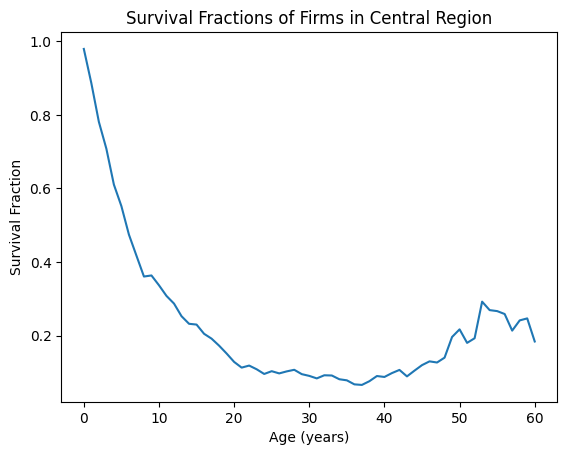

In [327]:
df_alivecr = df_central.copy()
df_alivecr['Age rounded'] = df_alivecr['Age'].round().astype(int)
# Convert Entry Date to only show the year
df_alivecr['Entry Date'] = df_alivecr['Entry Date'].dt.year
df_alivecr.head()

# Create list of 61 years from 1962 to 2022
years = np.arange(1962, 2023, 1)
years = years[::-1]
print(years)

# Create list of ages from 0 to 60
ages = np.arange(0, 61, 1)

# Create list of alive firms for each year
alive_counts = []
for year in years:
    alive_count = df_alivecr[
        (df_alivecr['Entry Date'] == year) &
        (df_alivecr['Exit Date'].isna())
    ].shape[0]
    alive_counts.append(alive_count)

print(alive_counts)

# Create list of dead firms for each year
dead_counts = []
for year in years:
    dead_count = df_alivecr[
        (df_alivecr['Entry Date'] == year) &
        (df_alivecr['status'] == 0)
    ].shape[0]
    dead_counts.append(dead_count)

print(dead_counts)

# Create list of survival fractions
survival_fractions = np.array(alive_counts) / (np.array(alive_counts) + np.array(dead_counts))
print(survival_fractions)

plt.plot(ages, survival_fractions)
plt.title('Survival Fractions of Firms in Central Region')
plt.xlabel('Age (years)')
plt.ylabel('Survival Fraction')
plt.show()

In [302]:
df_agedistribution.head()

,uen,Sector,status,Entry Date,Exit Date,Age,Region2
0,53376145W,N,0,2018-01-13 10:32:56,2020-04-30 09:36:00,2.291581,NR
1,53290857X,S,1,2015-02-26 12:02:44,NaT,7.841205,CR
3,200412424K,G,1,2004-09-28 17:56:29,NaT,18.253251,WR
4,53396472E,H,0,2019-04-11 21:20:43,2020-10-10 09:36:00,1.497604,CR
5,48376900B,S,0,1993-04-12 00:00:00,1999-12-24 04:48:00,6.699521,NER


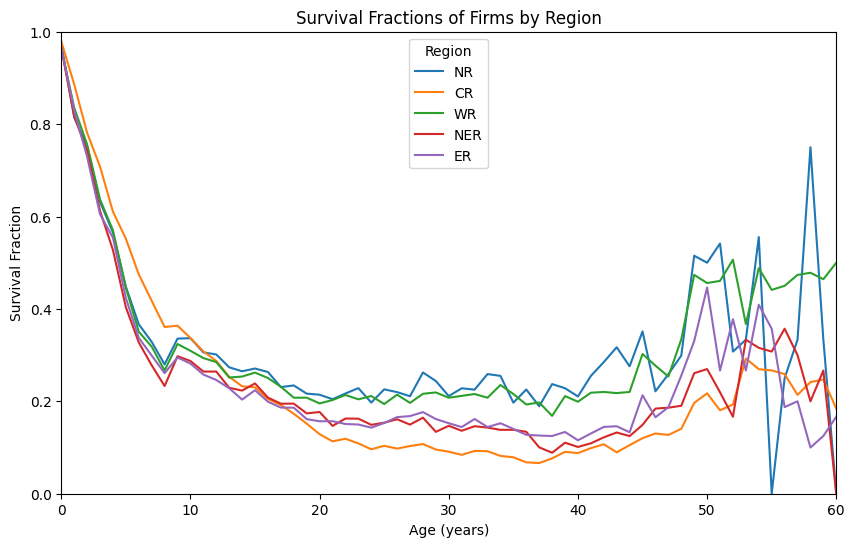

In [331]:
# Plot survival fractions against age for each region

regions_list = df_agedistribution['Region2'].unique()

# Create list of 61 years from 1962 to 2022
years = np.arange(1962, 2023, 1)
years = years[::-1]

# Create list of ages from 0 to 60
ages = np.arange(0, 61, 1)

plt.figure(figsize=(10, 6))

for region in regions_list:
    df_region = df_agedistribution.copy()
    df_region = df_region[df_region['Region2'] == region]
    # Convert Entry Date to only show the year
    df_region['Entry Date'] = df_region['Entry Date'].dt.year

    # Create list of alive firms for each year
    alive_counts = []
    for year in years:
        alive_count = df_region[
            (df_region['Entry Date'] == year) &
            (df_region['Exit Date'].isna())
        ].shape[0]
        alive_counts.append(alive_count)

    # Create list of dead firms for each year
    dead_counts = []
    for year in years:
        dead_count = df_region[
            (df_region['Entry Date'] == year) &
            (df_region['status'] == 0)
        ].shape[0]
        dead_counts.append(dead_count)

    # Create list of survival fractions
    survival_fractions = np.array(alive_counts) / (np.array(alive_counts) + np.array(dead_counts))

    plt.plot(ages, survival_fractions, label=region)

plt.title('Survival Fractions of Firms by Region')
plt.xlabel('Age (years)')
plt.ylabel('Survival Fraction')
plt.legend(title='Region')
plt.xlim(0, 60)
plt.ylim(0, 1)
plt.show()